We first are going to import all our necessary libraries:

In [523]:
import pandas as pd
import numpy as np
import scipy.stats as stats

Next, we import the databases from CSVs

In [524]:
fed_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
print(fed_df.to_markdown())

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
|   0 |   1954 |       7 |     1 |                    nan      |                       nan    |                       nan    |                           0.8  |                         4.6 |                 5.8 |            nan   |
|   1 |   1954 |       8 |     1 |                    nan      |                       nan    |                       nan    |                           1.22 |                       nan   |                 6   |            nan   |
|   2 |   1954 |       9 |     1 |                    nan      |            

Find how much of everything is missing:

In [525]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64


Seems like quite a bit...

All we need to fix is the effective rate, the unemployment and inflation. Lets do that.

First, lets fix the Target Rate

In [526]:
#print(fed_df[pd.isnull(fed_df['Effective Federal Funds Rate'])].to_markdown())

# We can see from here that there are two cases: Either we have a target rate, or we have an upper and lower rate. We will calculate the federal funds rate as follows
# If we have the case of a Target Rate, set the effective rate to the target rate
# If we have the case of an upper and lower target, set the effective rate to the mean of the two.

debugList = fed_df[pd.isna(fed_df['Effective Federal Funds Rate']) & pd.isna(fed_df['Federal Funds Target Rate'])]

def fixEffectiveFundsRate(series):
    naArray = pd.isna(series)
    if(naArray['Effective Federal Funds Rate']):
        if(not naArray['Federal Funds Target Rate']):
            return series['Federal Funds Target Rate']
        elif(not(naArray['Federal Funds Upper Target'] or naArray['Federal Funds Lower Target'])):
            #print((series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2)
            return (series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2
        return "ERROR PLEASE EXAMINE"
    return series['Effective Federal Funds Rate']

fed_df['Effective Federal Funds Rate'] = fed_df.apply(fixEffectiveFundsRate, axis=1)

print("\n")
#print(fed_df[pd.isnull(fed_df['Effective Federal Funds Rate'])].to_markdown())

Next, Unemployment

In [527]:
#print(fed_df[pd.isnull(fed_df['Unemployment Rate'])].to_markdown())
#print('\n')
#We see that for every null unemployment, we have a null inflation as well. The only nonnull we have consistently is effective rate. The other non-null rates are the target, the lower and upper rate, but we only either have target or upper+lower.
# I will use Mode Imputation to fill in the unemployments based on Effective Federal Funds Rate

grouped_unemployments = fed_df.groupby(['Effective Federal Funds Rate'])['Unemployment Rate'].apply(pd.Series.mode)
#print(grouped_unemployments.to_json())
test = (grouped_unemployments.to_dict())
ordered_dict = {}
for i in test:
    if(i[0] not in ordered_dict):
        ordered_dict[i[0]] = []
    else:
        if(test[i] in ordered_dict[i[0]]):
            print("ERROR")
        ordered_dict[i[0]].append(test[i])
#print(ordered_dict)

for i in fed_df['Effective Federal Funds Rate']:
    if(i in ordered_dict):
        pass
        #print(ordered_dict[i])
    else:
        ordered_dict[i] = []

for i in list(ordered_dict):
    if(ordered_dict[i]==[]):
        del ordered_dict[i]


def findClosestKey(dictionary,inputKey):
    if(inputKey in dictionary):
        return inputKey
    keys = dictionary.keys()
    #print(keys)
    toReturn = None
    for key in keys: # iterate through each key
        if(toReturn == None):
            toReturn = key
        if(abs(inputKey-key) < abs(inputKey-toReturn)): # if the current key is closer than our supposed closest, set this one as closest
            toReturn = key # set out new closest
    return toReturn

def fixUnemployment(series):
    naArray = pd.isna(series)
    if(naArray['Unemployment Rate']):
        key = findClosestKey(ordered_dict,series['Effective Federal Funds Rate'])
        return (sum(ordered_dict[key])/len(ordered_dict[key]))
    return series['Unemployment Rate']
fed_df['Unemployment Rate'] = fed_df.apply(fixUnemployment, axis=1)

And Finally, Inflation

In [528]:
# print(fed_df[pd.isnull(fed_df['Inflation Rate'])].to_markdown())
# print('\n')

grouped_inflation = fed_df.groupby(['Effective Federal Funds Rate','Unemployment Rate'])['Inflation Rate'].agg(pd.Series.mode)
#print(grouped_inflation.to_markdown())
for index, value in grouped_inflation.items():
    if(value.size==0):
        grouped_inflation.pop(index)

# test = grouped_inflation.index.map(lambda x: distance(x,input))

# test.min

def findNearestPoint(lst, input):
    distances = lst.index.map(lambda x: distance(x, input))
    #print(lst[np.argmin(distances)])
    return np.argmin(distances)

def distance(indexOne, indexTwo):
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(indexOne, indexTwo)))

def fixInflation(series):
    naArray = pd.isna(series)
    if(naArray['Inflation Rate']):
        index = findNearestPoint(grouped_inflation, (series['Effective Federal Funds Rate'],series['Unemployment Rate']))
        result = grouped_inflation.iat[index]
        if(type(result)==np.ndarray):
            result = sum(result)/len(result)
        return result
    return series['Inflation Rate']

fed_df['Inflation Rate'] = fed_df.apply(fixInflation, axis=1)

Now we verify that there are no more nulls in our desired categories

In [529]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate      0
Real GDP (Percent Change)       654
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


(45187.31893682355, 1.692741910395266e-73, 39858, array([[0.04977876, 0.04424779, 0.00553097, ..., 0.00553097, 0.01659292,
        0.01106195],
       [0.06969027, 0.0619469 , 0.00774336, ..., 0.00774336, 0.02323009,
        0.01548673],
       [0.12942478, 0.11504425, 0.01438053, ..., 0.01438053, 0.04314159,
        0.02876106],
       ...,
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239]]))


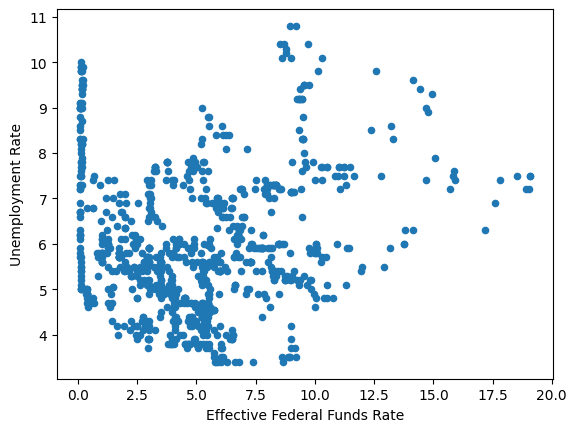

In [533]:
unemployment_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_crosstable)
print(result) # the 2nd value is the p value
unemployment_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')

(72221.00072380164, 0.0, 54677, array([[0.00553097, 0.01106195, 0.01659292, ..., 0.00553097, 0.01659292,
        0.00553097],
       [0.00774336, 0.01548673, 0.02323009, ..., 0.00774336, 0.02323009,
        0.00774336],
       [0.01438053, 0.02876106, 0.04314159, ..., 0.01438053, 0.04314159,
        0.01438053],
       ...,
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619]]))


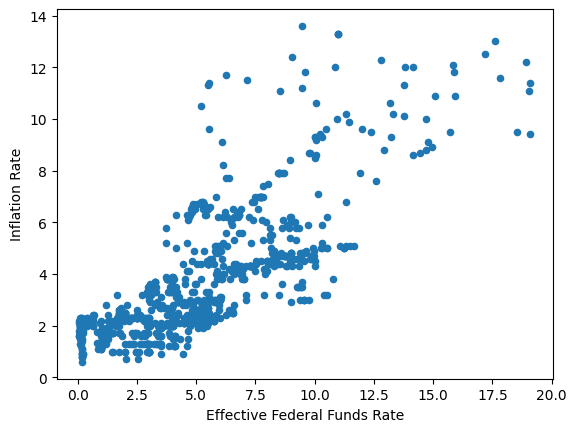

In [536]:
inflation_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_crosstable)
print(result) # the 2nd value is the p value
inflation_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')

<AxesSubplot: xlabel='Effective Federal Funds Rate', ylabel='Inflation Rate'>

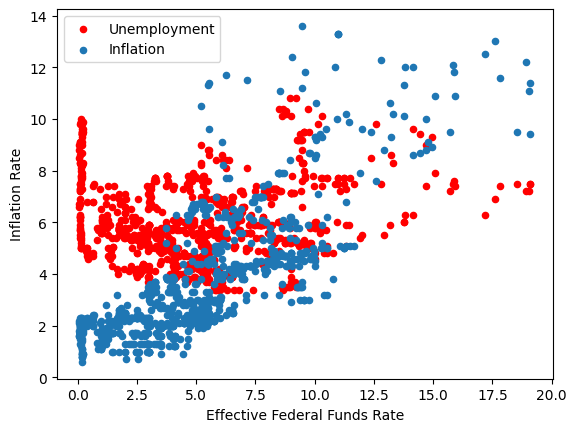

In [548]:
ax = fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Unemployment Rate',color='red',label='Unemployment',legend=True)
fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Inflation Rate',label='Inflation',legend=True,ax=ax)

Another possible method: drop Nulls

In [542]:
fed_nonnull_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
fed_nonnull_df = fed_nonnull_df.dropna(subset=['Effective Federal Funds Rate','Unemployment Rate','Inflation Rate'])
print(fed_nonnull_df.isnull().sum())


Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       395
Federal Funds Upper Target      612
Federal Funds Lower Target      612
Effective Federal Funds Rate      0
Real GDP (Percent Change)       474
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


Repeat Calculations for this new table

(54625.57824755772, 5.408463068011238e-144, 46410, array([[0.00704225, 0.01408451, 0.02112676, ..., 0.00704225, 0.00704225,
        0.00704225],
       [0.00985915, 0.01971831, 0.02957746, ..., 0.00985915, 0.00985915,
        0.00985915],
       [0.01830986, 0.03661972, 0.05492958, ..., 0.01830986, 0.01830986,
        0.01830986],
       ...,
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845]]))


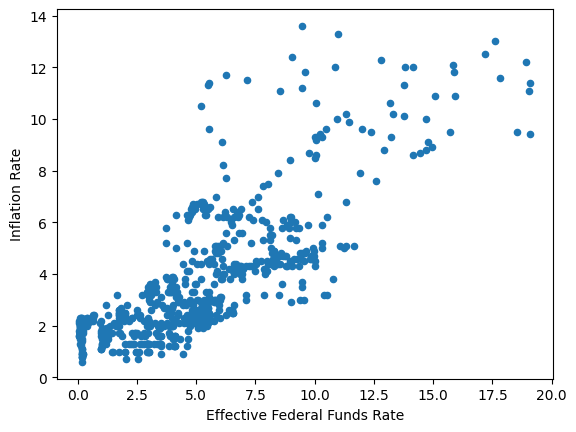

In [543]:
inflation_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_second_crosstable)
print(result) # the 2nd value is the p value
inflation_second_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')

(30520.626727085353, 0.954569245406529, 30940, array([[0.06338028, 0.05633803, 0.00704225, ..., 0.00704225, 0.02112676,
        0.01408451],
       [0.08873239, 0.07887324, 0.00985915, ..., 0.00985915, 0.02957746,
        0.01971831],
       [0.16478873, 0.14647887, 0.01830986, ..., 0.01830986, 0.05492958,
        0.03661972],
       ...,
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ]]))


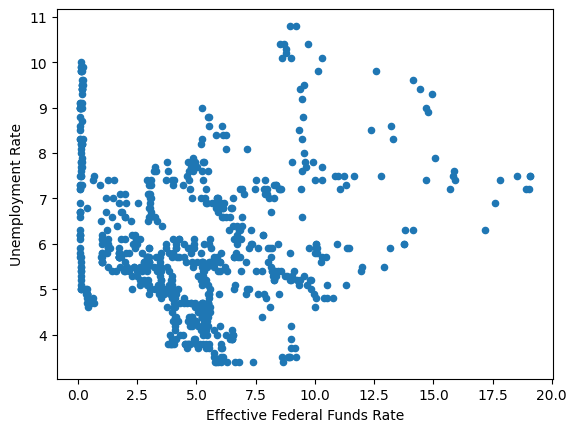

In [544]:
unemployment_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_second_crosstable)
print(result) # the 2nd value is the p value
unemployment_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')

<AxesSubplot: xlabel='Effective Federal Funds Rate', ylabel='Inflation Rate'>

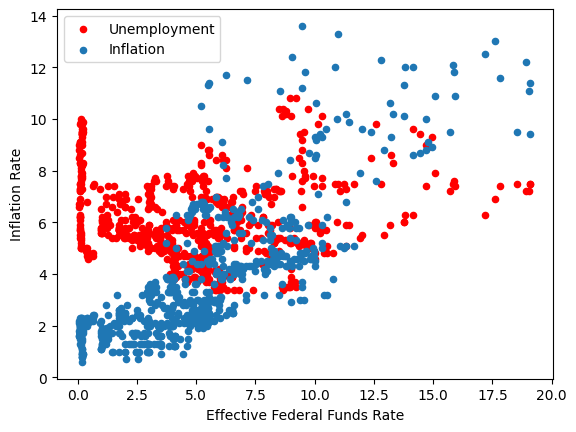

In [547]:
ax = fed_nonnull_df.plot.scatter(x='Effective Federal Funds Rate',y='Unemployment Rate',color='red',label='Unemployment',legend=True)
fed_nonnull_df.plot.scatter(x='Effective Federal Funds Rate',y='Inflation Rate',label='Inflation',legend=True,ax=ax)

Seemingly, dropping nulls had no real impact on the p value for inflation (went from 0 to pretty much 0), but unemployment went from significantly almost 0 to 0.95, a HUGE jump. Will investigate below

Lets try out MICE Imputation